<h1 align=center>Unsupervised Anomaly Sensor Detection - IMS Bearing NASA Acoustics and Vibration Database</h1>

<h3 align=center>PyCaret Anomaly detection Models vs - BiLSTM Autoencoder</h3>

## 1. Introduction

In this project 4 unsupervised anomaly detection models from Pycaret will be used to detect anomalies in sensor bearing sensor signal. These models are: Decision Tree and Support Vector Machine. In addition, a customed LSTM model will be built using the PyTorch Framework to autoencode and decode the signal input. The data comprises three vibrational sensor readings from the NASA Acoustics and Vibration Database. The datasets contained text files with 1-second vibration signal snapshots (20,480 data points) recorded at 5 and 10 minute intervals at a sampling rate of 20 kHz.

* Pycaret is a high-performance, open-source, low code library for ML modeling. It provides highly-efficient CPU/GPU implementations of ML models for  cluster analysis, classification,  time series and anomaly detection. Snap ML not only accelerates ML algorithms through system awareness, but also offers novel ML algorithms with best-in-class accuracy. Pycaret also automates ML workflows and aims to democratize ML. For more information, please visit [here](https://pycaret.org/).

* PyTorch is a machine learning framework used for applications such as computer vision and natural language processing, originally developed by Meta AI and now part of the Linux Foundation umbrella. For more information, please visit [here](https://pytorch.org/).

## 2. Tasks

The objective of this piece of work is to identify the best model(s) than can anticipate potential sensor failures at the earliest stage in an unsupervised fashion using low code and deep learnig models.

1. Visualize the data an applied tranformations.
2. Detect anomalies from sensor vibration signals using Pycaret anomaly detection models.
3. Buid BiLSTM artificial neural networks to predict anomalies and train models.
4. Visualize the results with plot
5. Test the models with an idependent dataset
6. Measure the goodness of the clusters generated using in usupervised clustering metrics
7. Compare the performance of the model using non-parametric statistics
8. Conclusion


## Dataset

The data comprises three datasets vibrational sensor readings from the NASA Acoustics and Vibration Database. The datasets contained text files with 1-second vibration signal snapshots (20,480 data points) recorded at 5 and 10 minute intervals at a sampling rate of 20 kHz. Each datset contains reading at from four sensors.

The dataset is available on [kaggle](https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset).

## Installing required libraries

In [1]:
!pip install pycaret
!pip install mlflow
!pip install umap-learn
!pip install seaborn
# !pip install git+https://github.com/maximtrp/scikit-posthocs.git
!pip install scikit-posthocs
!pip install natsort

## Importing require libraries

In [2]:
# Import libraries
import os, gc
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1234)

from pycaret.anomaly import *

## Import supportig scripts

In [3]:
from concat_datasets import concat_raw_data, average_signal_dataset, dir_list
from plots import *

# Datasets processing

Data can be processed by changing the ```concat_data``` to True or running the script ```concat_datasets.py```. The ```txt``` dataset are concatenated and put together into one file per dataset test. In addition, data was transform (denoised) using the packag Scipy Fast Fourier Transforms (fft).

For the purpose of this work we will use the concatenated data with average reading for each of the 204080 sample points.

In [4]:
datasets = {'dataset_path1' : './ims_bearing/1st_test/1st_test',
           'dataset_path2' : './ims_bearing/2nd_test/2nd_test',
           'dataset_path3' : './ims_bearing/3rd_test/4th_test/txt'}

In [5]:
csv_data = os.path.join(os.getcwd(), 'csv_data')
os.makedirs(csv_data, exist_ok=True)

In [6]:
# concat_data = False
# def generate_datasets(datasets_dict=datasets, csv_path=csv_data):
#     for i, (k, v) in enumerate(datasets_dict.items()):
#         dataset_num = i + 1
#         average_signal_dataset(v, dataset=dataset_num, csv_path=csv_path)
#         concat_raw_data(v, csv_path, dataset=dataset_num, fourier_tr=True, detrends=False)

# if concat_data:
#     generate_datasets(datasets)

# Exploratory Data Analysis EDA

In [7]:
fft_dataset = [d for d in dir_list(csv_data) if 'fft' in d]
avg_dataset = [d for d in dir_list(csv_data) if not 'fft' in d]

In [8]:
def read_concat_data(path=None, fname=None):
    df = pd.read_csv(os.path.join(path, fname), index_col=0)
    df.index = pd.to_datetime(df.index)
    return df

In [9]:
avg_dataset

['avg_concat_dataset_1.csv',
 'avg_concat_dataset_2.csv',
 'avg_concat_dataset_3.csv']

In [10]:
avg_df1 = read_concat_data(csv_data, fname=avg_dataset[0])
print(f'Dataset size: {len(avg_df1)}')
avg_df1.describe()

Dataset size: 2156


,b1_ch1,b1_ch2,b2_ch3,b2_ch4,b3_ch5,b3_ch6,b4_ch7,b4_ch8
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.127485,0.124183,0.125529,0.120615,0.132830,0.134874,0.124395,0.125285
std,0.006072,0.006244,0.005745,0.005540,0.014742,0.014387,0.014100,0.013660
min,0.103652,0.099853,0.106503,0.101036,0.106148,0.108152,0.048433,0.069658
25%,0.127832,0.124815,0.125422,0.120932,0.131230,0.133210,0.118644,0.119841
50%,0.128904,0.125841,0.126129,0.121639,0.132255,0.134239,0.120240,0.121462
75%,0.129828,0.126581,0.127190,0.122351,0.133679,0.135751,0.129112,0.131733
max,0.142146,0.132984,0.170624,0.162340,0.438412,0.364026,0.229181,0.221456


In [11]:
avg_df2 = read_concat_data(csv_data, fname=avg_dataset[1])
print(f'Dataset size: {len(avg_df2)}')
avg_df2.describe()

Dataset size: 984


,b1_ch1,b2_ch2,b3_ch3,b4_ch4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060764,0.074232,0.076830,0.043949
50%,0.062005,0.075202,0.078197,0.044523
75%,0.083222,0.077462,0.080597,0.048110
max,0.453318,0.161011,0.151296,0.119042


In [12]:
avg_df3 = read_concat_data(csv_data, fname=avg_dataset[2])
print(f'Dataset size: {len(avg_df3)}')
avg_df3.describe()

Dataset size: 6324


,b1_ch1,b2_ch2,b3_ch3,b4_ch4
count,6324.000000,6324.000000,6324.000000,6324.000000
mean,0.058445,0.064602,0.057390,0.044168
std,0.005061,0.009270,0.023149,0.011082
min,0.001533,0.002441,0.003663,0.001428
25%,0.056456,0.061596,0.052594,0.040506
50%,0.057657,0.062778,0.053941,0.043425
75%,0.059215,0.064786,0.055309,0.044282
max,0.122481,0.224447,0.543762,0.244888


In [ ]:
# Release resources del the daset not used
# del avg_df1
# gc.collect()

## Visualise

* For this piece of work only the average readings datasets 2 and 3 will be used.


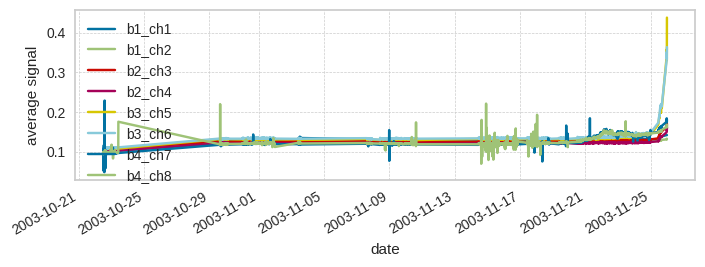

In [14]:
view_all(avg_df1, plot_name='avg_dataset1')

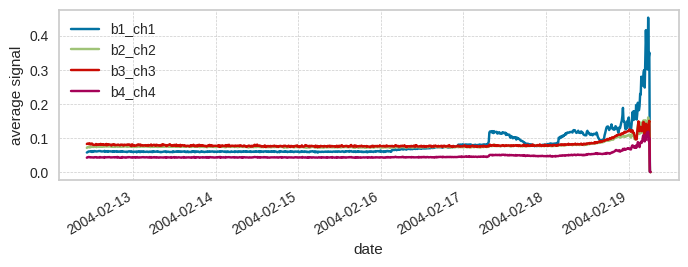

In [14]:
view_all(avg_df2, plot_name='avg_dataset2')

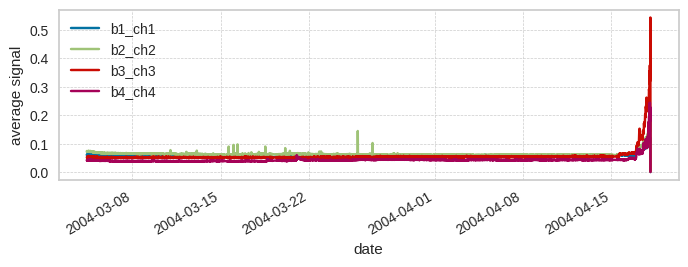

In [15]:
view_all(avg_df3, plot_name='avg_dataset3')

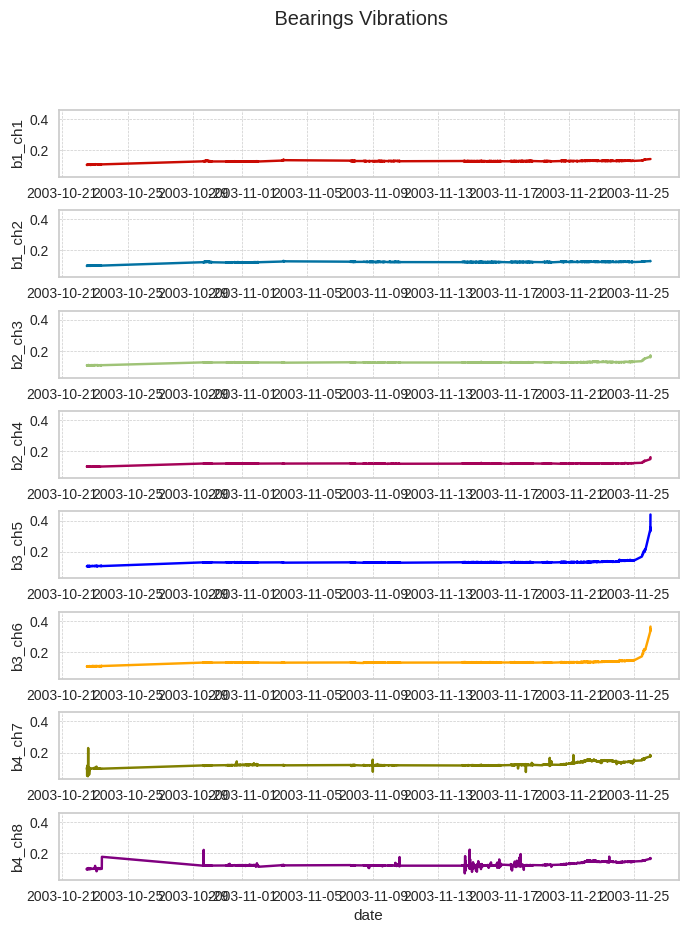

In [15]:
view_per_channel(avg_df1, plot_name='view_per_channel_avgdf1')

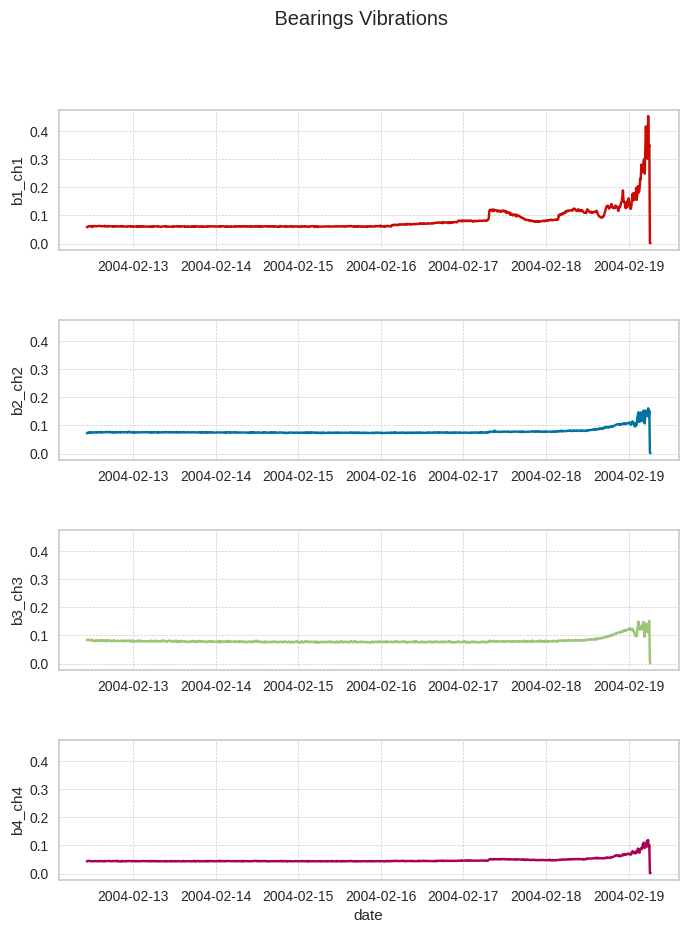

In [16]:
view_per_channel(avg_df2, plot_name='view_per_channel_avgdf2')

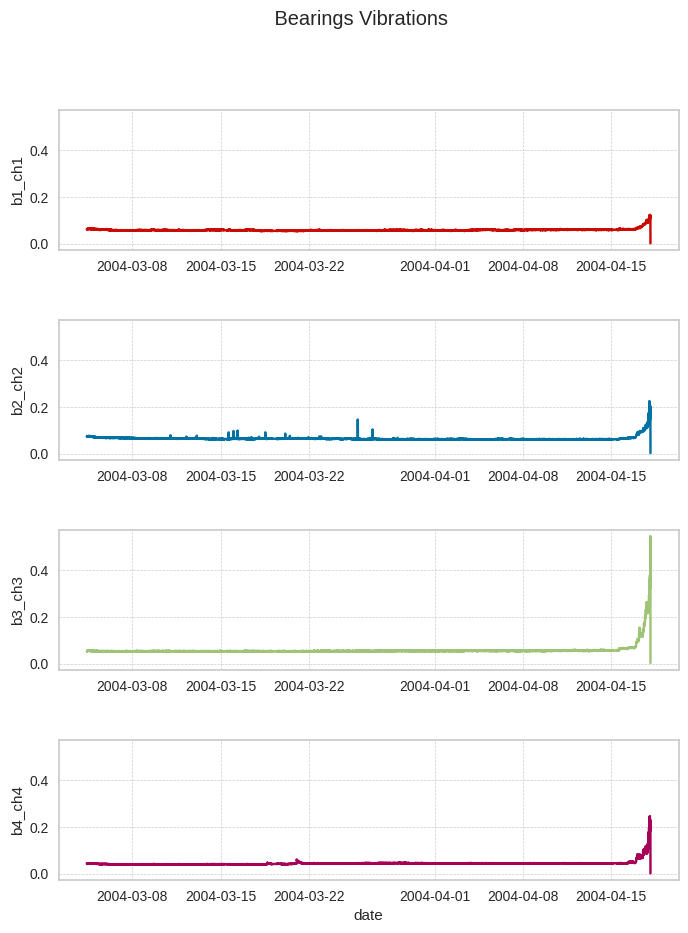

In [17]:
view_per_channel(avg_df3, plot_name='view_per_channel_avgdf3')

# Unsupervised Anomaly detection using PyCaret

The approach to unsupervised machine learning is:

* Dataset `avg_df2` will be used to train the model and to obtain the anomaly labels.
* The best models will be tested on unseen data , dataset `avg_df3`.
    
    

In [18]:
# Create directoty to save anomalies for model comparison
csv_files = os.path.join(os.getcwd(), 'csv_files')
os.makedirs(csv_files, exist_ok=True)

In [19]:
# initiate setup
exp = setup(avg_df2, session_id=123, log_experiment=False, use_gpu=True)

,Description,Value
0,Session id,123
1,Original data shape,"(984, 4)"
2,Transformed data shape,"(984, 4)"
3,Numeric features,4
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,CPU Jobs,-1
9,Use GPU,True


In [20]:
exp.get_config()

{'USI',
 'X',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables'}

In [21]:
# Show avaialable models
all_anomaly_models = models()
all_anomaly_models

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pycaret.internal.patches.pyod.CBLOFForceToDouble
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


## Model Selection

* Isolation Forest **iforest**
* Minimum Covariance Determinant **mcd**
* Clustering-Based Local outlier **cluster**
* One Class SVM **svm**
* Histogram-based Outlier Detection **histogram**
* K-Nearest Neighbors Detector **knn**

In [22]:
selected_models = ['cluster', 'histogram', 'iforest', 'knn', 'mcd', 'svm']

### Build train and predict fuction

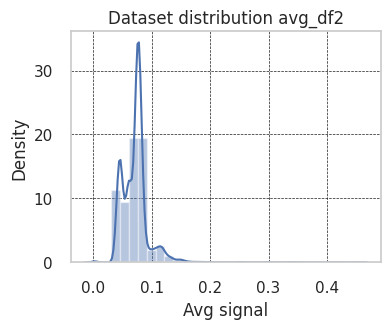

In [23]:
sns.set(rc={'figure.figsize': (4, 3)})
sns.set_style('whitegrid')
sns.distplot(avg_df2.values, bins=30, kde=True)
plt.grid(color ='k', ls= '--', lw=0.5)
plt.xlabel('Avg signal')
plt.title('Dataset distribution avg_df2')
plt.show()

In [24]:
np.percentile(avg_df3.values, [80, 85, 90, 91, 92, 93, 95, 98, 99])

array([0.06192544, 0.06287408, 0.06436785, 0.0646797 , 0.06500517,
       0.0654315 , 0.06681847, 0.08007517, 0.10683016])

__Note__: We will used the default contamination of 0.05, this to prevent over fitting and test the model on unseen data(avg_df3).

In [25]:
def train_model(model_name=None, fraction=None):

    print(f'Assigning labels: {model_name} model')
    model = create_model(model_name, fraction=fraction)
    model_anomalies = assign_model(model)
    unique_labels = model_anomalies.Anomaly.unique()
    print(f'Unique labels: {unique_labels}')
    save_model(model, f'{model_name}_pipeline')
    return model_anomalies


In [26]:
def main(anomly_model_list=None, fraction=None):

    results_dict = {}
    anomaly_scores = {}
    for m in anomly_model_list:
        results = train_model(m, fraction=fraction)
        results_dict[m] = results.Anomaly
        anomaly_scores[m] = results.Anomaly_Score
        results_filter = results[results.Anomaly == 1]
        print(f'Anomalies detected by {m} model')
        print(f'Anomalous readings: {len(results_filter)}')
        print(' ')

    df_anomalies = pd.DataFrame.from_dict(results_dict)
    df_scores = pd.DataFrame.from_dict(anomaly_scores)

    return df_anomalies, df_scores

##  Run the training

In [27]:
anomaly_df, scores_df = main(selected_models, fraction=0.05)

Assigning labels: cluster model


Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by cluster model
Anomalous readings: 50
 
Assigning labels: histogram model


Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by histogram model
Anomalous readings: 50
 
Assigning labels: iforest model


Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by iforest model
Anomalous readings: 50
 
Assigning labels: knn model


Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by knn model
Anomalous readings: 50
 
Assigning labels: mcd model


Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by mcd model
Anomalous readings: 50
 
Assigning labels: svm model


Unique labels: [0 1]
Transformation Pipeline and Model Successfully Saved
Anomalies detected by svm model
Anomalous readings: 50
 


In [28]:
# Save results for future comparison
anomaly_df.to_csv(os.path.join(csv_files, 'unsupervised_anomaly_pred.csv'))
scores_df.to_csv(os.path.join(csv_files, 'unsupervised_scores_pred.csv'))

## Visualize models results


All models detected anomalies only at the end of the test on avg_df2 dataset. It is not apparent
which model detectes earliest an anomalous signal.

These models detected anomalies mainly atthe begining of the test and at the end.

It can also be observed that anomalies were detected at the begining of the test in all models. KNN
model detected anomalies all along the test meanwhile SVM detected anomalies for the first half
of the test and at the end it.

In [29]:
print('Anomalies detected by model', anomaly_df.sum(axis=0), sep='\n')

Anomalies detected by model
cluster      50
histogram    50
iforest      50
knn          50
mcd          50
svm          50
dtype: int64


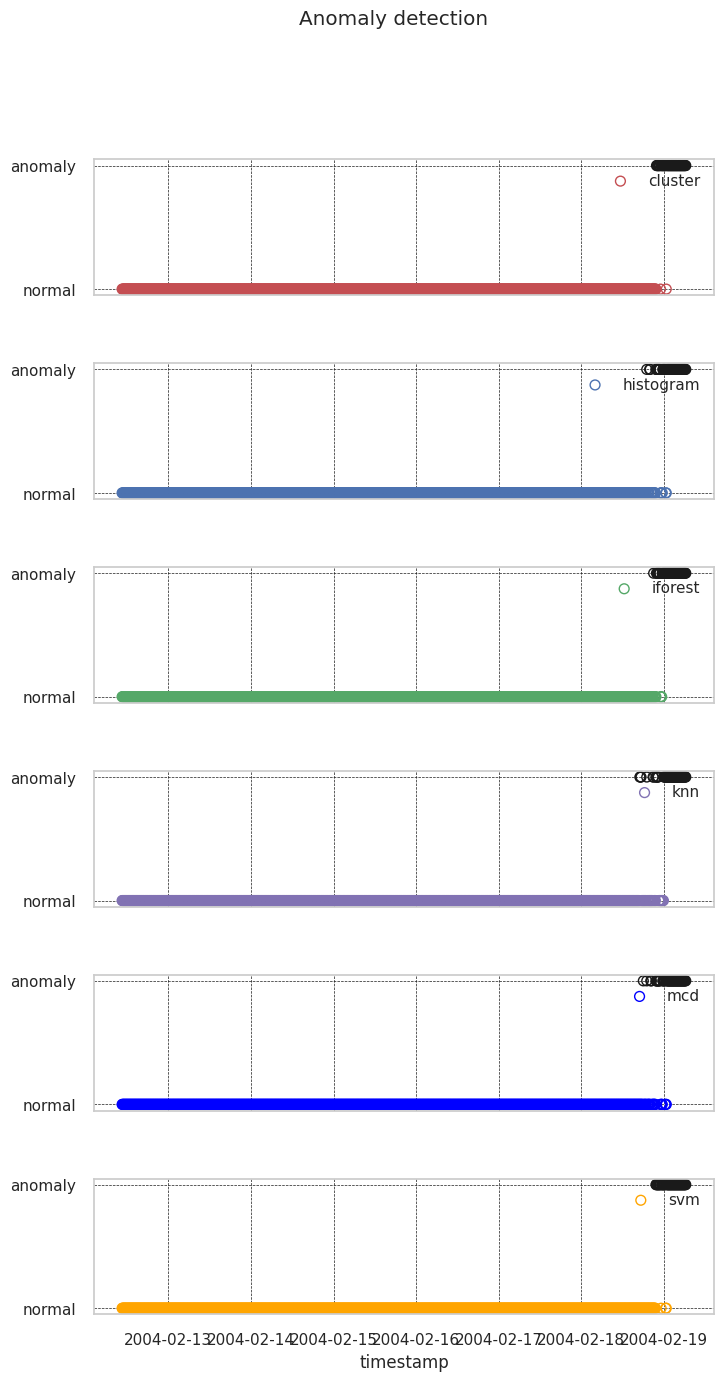

In [30]:
scatter_anomalies_plot(anomaly_df, 'anomalies')

In [31]:
train_anomalies = anomaly_df[(anomaly_df.index >= '2004-02-15') & (anomaly_df.sum(axis=1)>=1)]

In [32]:
print(f'The first anomaly detected from 2004-02-15 was on {train_anomalies.index[0]}')
print(f'Model: {train_anomalies.columns[np.where(train_anomalies.iloc[0].values)[0]][0]}')

The first anomaly detected from 2004-02-15 was on 2004-02-18 17:02:39
Model: knn


In [33]:
train_anomalies.head()

,cluster,histogram,iforest,knn,mcd,svm
2004-02-18 17:02:39,0,0,0,1,0,0
2004-02-18 17:12:39,0,0,0,1,0,0
2004-02-18 17:22:39,0,0,0,1,0,0
2004-02-18 18:02:39,0,0,0,0,1,0
2004-02-18 19:02:39,0,1,0,1,1,0


In [34]:
print('Anomalies detected by model from 2004-04-15:', train_anomalies.sum(axis=0), sep='\n')

Anomalies detected by model from 2004-04-15:
cluster      50
histogram    50
iforest      50
knn          50
mcd          50
svm          50
dtype: int64


In [35]:
# Get time stamps at which at leats one models detected an anomaly on each timestamp
print(f'One or more models detected an anomaly in {len(train_anomalies)} timestamps')

One or more models detected an anomaly in 64 timestamps


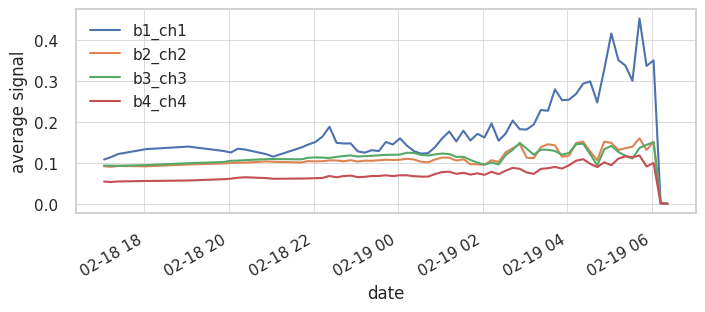

In [36]:
avg_df2.loc[train_anomalies.index].plot(xlabel='date', ylabel='average signal', figsize=(8,3))
plt.grid(True, lw=0.5)
plt.show()

In [37]:
common_detected_anomaly = train_anomalies[train_anomalies.sum(axis=1) == 6].index
print(f'All models detected anomalies in {len(common_detected_anomaly)} common timestamps')

All models detected anomalies in 40 common timestamps


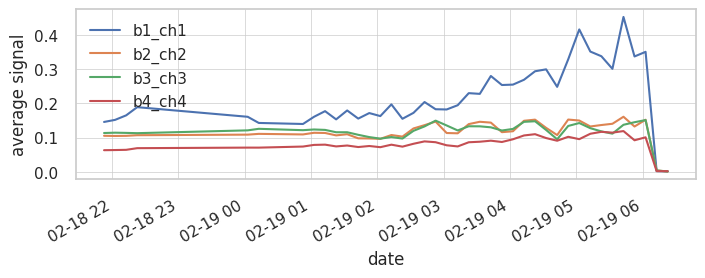

In [38]:
avg_df2.loc[common_detected_anomaly].plot(xlabel='date', ylabel='average signal', figsize=(8,2.5))
plt.grid(True, lw=0.5)
plt.show()

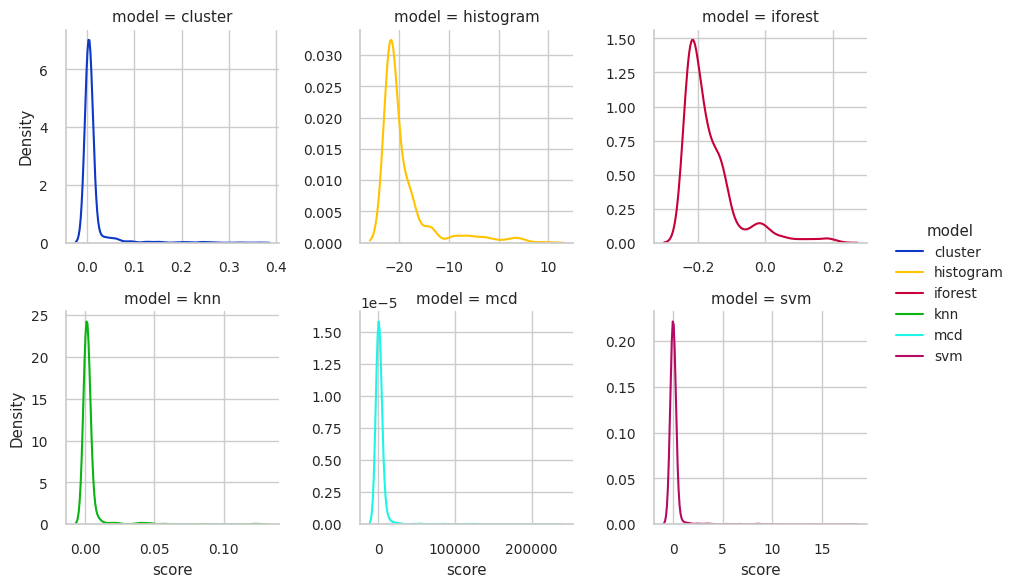

In [39]:
plot_scores_distribution(scores_df, plot_name='train_scores')

In [40]:
models_ = train_anomalies[train_anomalies.sum(axis=1)>1].iloc[0]
print('The earliest that a failure could have been detected by more than one model was:')
print(f'{models_.iloc[np.where(models_.values ==1)]}')

The earliest that a failure could have been detected by more than one model was:
histogram    1
knn          1
mcd          1
Name: 2004-02-18 19:02:39, dtype: int64


In [41]:
print('The earliest that the failure could have been detected by all models was:')
print(f'{common_detected_anomaly[0]}')

The earliest that the failure could have been detected by all models was:
2004-02-18 21:52:39


In [42]:
print(f'Time for preventive maintenace before failure with at least one model detecting an anomaly:')
print(train_anomalies.index[-1] - train_anomalies.index[0])
print(' ')
print(f'Time for preventive maintenace before failure detected by all models:')
print(train_anomalies.index[-1] - train_anomalies.nlargest(1, 'svm').index[0])

Time for preventive maintenace before failure with at least one model detecting an anomaly:
0 days 13:20:00
 
Time for preventive maintenace before failure detected by all models:
0 days 08:40:00


It is inconclusive which model performs better at detecting anomalies at early stage. We will further apply cluster metrics and non-paramentric test to compare the performace of the clusters formed. For the training dataset the model that detected anomlies the earliest was:

---

__Clustering-Based Local Outlier__

---
Next all models will be tested on the unseen dataset ```avg_df3```.

In [43]:
# Release resources del the daset not used
del anomaly_df, train_anomalies, scores_df, common_detected_anomaly
gc.collect()

20420

## Prediction on unseen data

In [44]:
def predict_anomaly(unseen_data=None, anomly_model_list=None, thresh=0.10, plot_3d=False,
                    fraction=0.05):

    best_models = dict()
    scores = dict()
    best_models_list = list()

    print(f'Unseen data size: {len(unseen_data)}')
    print('-'*58)
    for m in anomly_model_list:
        path_to_pipeline = os.path.join(os.getcwd(), f'{m}_pipeline')
        model = load_model(path_to_pipeline)
        model.fraction = fraction
        predictions = predict_model(model, data=unseen_data)
        anomalies = predictions[predictions.Anomaly == 1]
        print(f'{m} model detected {len(anomalies)} anomalies in the unseen data')
        print('='*58)
        if len(anomalies) >= (thresh * len(predictions)):
            continue
        else:
            if plot_3d:
                plot_model(model, plot='tsne')
            best_models[m] = predictions.Anomaly
            scores[m] = predictions.Anomaly_Score
            best_models_list.append(m)

    df_predictions = pd.DataFrame.from_dict(best_models)
    df_scores = pd.DataFrame.from_dict(scores)

    return  df_predictions, df_scores, best_models_list


In [45]:
unseen_preds, unseen_scores, models_list  = predict_anomaly(avg_df3, selected_models)

Unseen data size: 6324
----------------------------------------------------------
Transformation Pipeline and Model Successfully Loaded
cluster model detected 129 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
histogram model detected 4843 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
iforest model detected 187 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
knn model detected 6304 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
mcd model detected 78 anomalies in the unseen data
Transformation Pipeline and Model Successfully Loaded
svm model detected 95 anomalies in the unseen data


In [46]:
unseen_preds.to_csv(os.path.join(csv_files, 'unsupervised_test_anomaly.csv'))
unseen_scores.to_csv(os.path.join(csv_files, 'unsupervised_test_scores.csv'))

In [47]:
unseen_preds.sum(axis=0)

cluster    129
iforest    187
mcd         78
svm         95
dtype: int64

In [48]:
test_anomalies = unseen_preds[unseen_preds.sum(axis=1) >= 1]

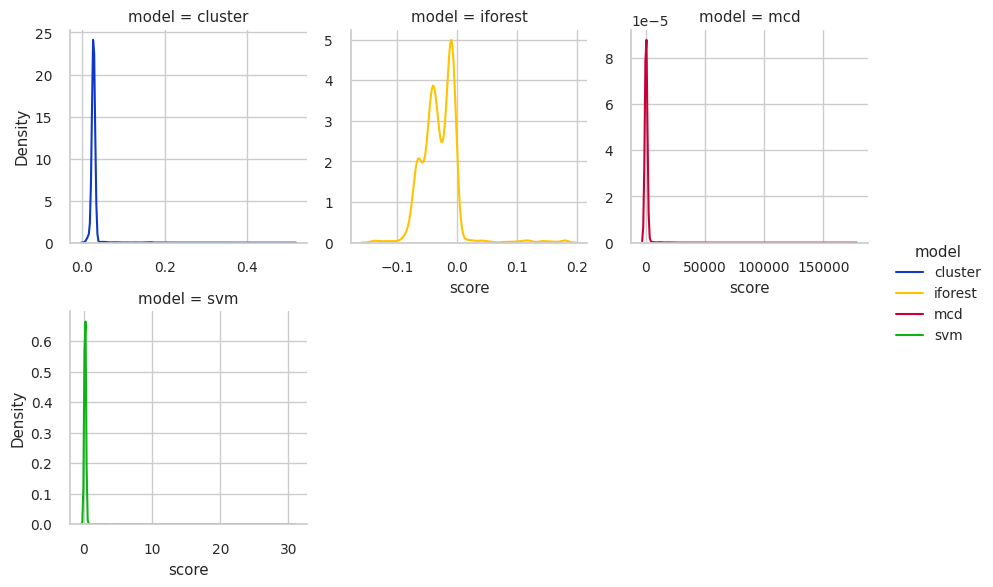

In [49]:
plot_scores_distribution(unseen_scores, size=(3, 2), plot_name='test_scores')

In [50]:
test_anomalies[(test_anomalies.index >= '2004-04-15') & (test_anomalies.sum(axis=1)>=1)][0:5]

,cluster,iforest,mcd,svm
2004-04-17 01:12:55,0,1,0,0
2004-04-17 01:22:55,0,1,0,0
2004-04-17 01:32:55,0,1,0,0
2004-04-17 01:42:55,0,1,0,0
2004-04-17 01:52:55,0,1,0,0


In [51]:
earliest_tail = test_anomalies[(test_anomalies.sum(axis=1)>=1) & (test_anomalies.index
                                                                 >= '2004-04-15')]

In [52]:
print(f'The earliest that the failure could have been detected was on :')
print(f"{test_anomalies[(test_anomalies.index >= '2004-04-15')].index[0]}")
print(f'Model: {test_anomalies.columns[np.where(test_anomalies.iloc[0].values)[0]][0]}')

The earliest that the failure could have been detected was on :
2004-04-17 01:12:55
Model: iforest


In [53]:
print(f'The earliest that a failure could have been detected by more than one model was:')
print(f'{earliest_tail[earliest_tail.sum(axis=1)>1].index[0]}')
print(earliest_tail.columns[np.where(earliest_tail[
    earliest_tail.sum(axis=1)>1].iloc[0]==1)].values)


The earliest that a failure could have been detected by more than one model was:
2004-04-17 02:02:55
['cluster' 'iforest']


In [54]:
print('The earliest the three models could have detected the failure was')
print(f'{earliest_tail[earliest_tail.sum(axis=1)==3].index[0]}')

The earliest the three models could have detected the failure was
2004-04-17 05:22:55


In [55]:
time_left = earliest_tail.index[-1] - earliest_tail.index[0]
print(f'Time to prevent failure: {time_left}')

Time to prevent failure: 1 days 01:30:00


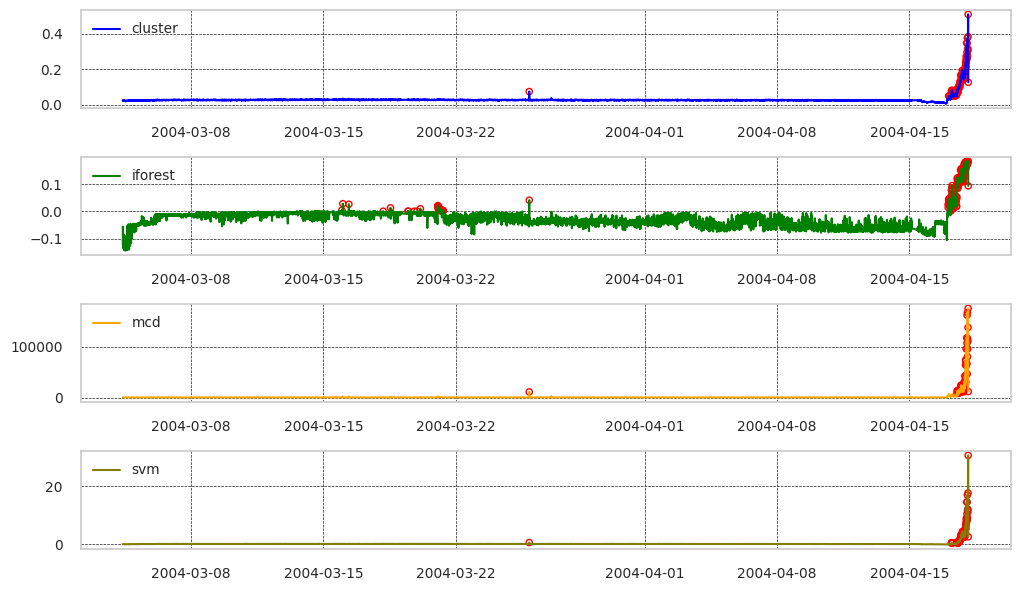

In [56]:
plot_predicted_anomalies(unseen_scores, test_anomalies, plot_name='test_anomaly_prediction')

**The best performances on the test dataset ```avg_df3``` were:**

1.   __iforest__
2.   __mcd__
3.   __svm__

In [57]:
del unseen_preds
del test_anomalies
del unseen_scores
del earliest_tail
gc.collect()

30313

# Multiseries Anomaly Prediction with Artificial Neural Networks -BiLSTM

In [58]:
from sklearn.preprocessing import MinMaxScaler
from collections import namedtuple
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
torch.manual_seed(1234)

Approach to deep learning:

* Built configurable Encoder - Decoder Model using PyTorch
* Process data - scaling
* Built training, evaluation and prediction functions
* Build the data loaders for batch processing, seelect, optimizers loss function and hyperparameters
* Experimental setup
* Train and validate model on avg_df3 dataset
* Visualise training metrics
* Test model on avg_df2
* Visualise tests metrics
* Optimize model

## Build configurable encoder-Decoder model - BiLSTM

In [59]:
class AnomalyLSTM(nn.Module):

    def __init__(self, input_size, hidden_dim=24, num_layers=2, p=0.1):
        super(AnomalyLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
          input_size=self.input_size,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          bidirectional=True,
          batch_first=True)

        self.linear1 = nn.Linear(self.hidden_dim * 2, 12)
        self.linear2 = nn.Linear(12, self.input_size)
        self.dropout = nn.Dropout1d(p)

    def forward(self, x):

        x= torch.tensor(x, dtype=torch.float32)
        lstm_out, hidden = self.lstm(x.view(-1, 1, self.input_size))
        out = torch.cat((hidden[0][-2, :, :], hidden[0][-1, :, :]), dim=1)
        out = F.relu(self.linear1(out))
        out = self.dropout(out)
        out = self.linear2(out)

        return out


## Process data

In [60]:
scaler = MinMaxScaler()
train_data = torch.tensor(scaler.fit_transform(avg_df2.values), dtype=torch.float32)
test_data = torch.tensor(scaler.transform(avg_df3.values), dtype=torch.float32)

## Build training, evaluation and  prediction functions

In [61]:
def train_one_epoch(**kwargs):
    """
    :param kwargs: hyperparameters dictionary
    :return:training los for one epoch
    """

    total_loss = 0
    model = kwargs['model'].to(kwargs['device'])
    model.train()

    for true_seq in kwargs['train_loader']:
        kwargs['optimizer'].zero_grad()
        true_seq = true_seq.to(device)
        pred_seq = model(true_seq)
        loss = kwargs['loss_fn'](pred_seq, true_seq)
        loss.backward()
        kwargs['optimizer'].step()
        total_loss += loss.item()

    return total_loss / len(kwargs['train_loader'])

In [62]:
def evaluate(**kwargs):
    """
    :param kwargs: a hyperparameters dictionary
    :return: evalution loss
    """

    total_loss = 0
    model = kwargs['model'].eval()
    with torch.no_grad():
        for true_seq in kwargs['eval_loader']:
            true_seq = true_seq.to(kwargs['device'])
            pred_seq = model(true_seq)
            loss = kwargs['loss_fn'](pred_seq, true_seq)
            total_loss += loss.item()

    return total_loss / len(kwargs['eval_loader'])

In [63]:
def time_minutes(s):
    """
    :param s:  time in seconds
    :return: time in hh:mm:ss format
    """
    return time.strftime('%H:%M:%S', time.gmtime(s))

In [64]:
def train_lstm(**kwargs):
    """
    :param kwargs: a hyperparameters dictionary
    :return: namedtuple - statistics
    """

    Stats = namedtuple('Stats', ['train_loss'])
    train_loss_log = np.zeros(kwargs['epochs'])
    best_loss = np.inf

    epoch_start_time = time.time()
    print('........Training Starting.......')
    for epoch in tqdm(range(kwargs['epochs'])):
        train_loss = train_one_epoch(**kwargs)
        train_loss_log[epoch] = train_loss
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save({'epoch': epoch + 1, 'model': kwargs['model'].state_dict(),
                'optim': kwargs['optimizer'].state_dict()},
                os.path.join(kwargs['params'], f"best_exp_{kwargs['exp']}.pt"))

        if (epoch + 1) % kwargs['logging'] == 0:
            print(' ')
            print('Epoch %d: | train loss: %.4f' % (epoch + 1, train_loss))

    total_time = time.time() - epoch_start_time
    print('Training time {}'.format(time_minutes(total_time)))
    stats = Stats(train_loss=train_loss_log)

    return stats

In [65]:
def predict(model, data_loader, loss_fn=None):

    preds_log, loss_log = [], []
    with torch.no_grad():
        model = model.eval()
        for seqs_batch in data_loader:
            for seq in seqs_batch:
                seq = seq.to(device)
                seq_pred = model(seq)
                loss = loss_fn(seq_pred, seq)
                preds_log.append(seq_pred.cpu().numpy().flatten())
                loss_log.append(loss.item())
    return preds_log, loss_log

In [66]:
exps =[i for i in range(1, 5)]
network = ['bilstm'] * 4
exp_optim = sorted(['adam', 'adamw'] * 2)
exp_loss = ['mae_loss', 'huber_loss'] * 2

exp_setup = pd.DataFrame({'Exp':exps, 'Model':network, 'Loss': exp_loss, 'Optim':exp_optim },
                         index=exps)
exp_setup.set_index('Exp', drop=True, inplace=True)

| Exp | Model  | Loss        | Optim |
|-----|--------|-------------|-------|
| 1   | bilstm | mae\_loss   | adam  |
| 2   | bilstm | huber\_loss | adam  |
| 3   | bilstm | mae\_loss   | adamw |
| 4   | bilstm | huber\_loss | adamw |

## Hyperparameter selection and training

In [67]:
batch = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bilstm_model = AnomalyLSTM(input_size=4, hidden_dim=32, num_layers=1, p=0.1).to(device)
print(bilstm_model)
learning_rate = 0.0002
mae_loss = nn.L1Loss('mean')
huber_loss = nn.SmoothL1Loss('mean')
adam_optim = optim.Adam(bilstm_model.parameters(), lr=learning_rate)
adamw_optim = optim.AdamW(bilstm_model.parameters(), lr=learning_rate)
train_loader = data.DataLoader(train_data, shuffle=False, batch_size=batch)
test_loader = data.DataLoader(test_data, shuffle=False, batch_size=batch)

AnomalyLSTM(
  (lstm): LSTM(4, 32, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=64, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=4, bias=True)
  (dropout): Dropout1d(p=0.1, inplace=False)
)


In [68]:
exp = 4
weights_dir = os.path.join(os.getcwd(), 'params')
os.makedirs(weights_dir, exist_ok=True)

config = {'exp': exp, 'epochs': 50,  'model':bilstm_model, 'loss_fn':mae_loss,
          'optimizer': adamw_optim, 'train_loader': train_loader,'eval_loader': test_loader,
          'device': device, 'logging': 10, 'params' : weights_dir}
if exp in [1, 2]:
    config['optimizer'] = adam_optim
if exp in [2, 4]:
    config['loss_fn'] = huber_loss
elif exp > 4:
    assert exp > 4, 'Experiment not in the experimental setup'

In [69]:
# Run experiments
print(f'Running experiment {exp}', f'{exp_setup.loc[exp]}', sep='\n')
training_metrics = train_lstm(**config)

Running experiment 4
Model        bilstm
Loss     huber_loss
Optim         adamw
Name: 4, dtype: object
........Training Starting.......


 22%|██▏       | 11/50 [00:01<00:03, 11.02it/s]

 
Epoch 10: | train loss: 0.0297


 42%|████▏     | 21/50 [00:01<00:02, 11.64it/s]

 
Epoch 20: | train loss: 0.0132


 62%|██████▏   | 31/50 [00:02<00:01, 11.89it/s]

 
Epoch 30: | train loss: 0.0124


 82%|████████▏ | 41/50 [00:03<00:00, 11.86it/s]

 
Epoch 40: | train loss: 0.0113


100%|██████████| 50/50 [00:04<00:00, 11.37it/s]

 
Epoch 50: | train loss: 0.0119
Training time 00:00:04


  ## Metrics visualization

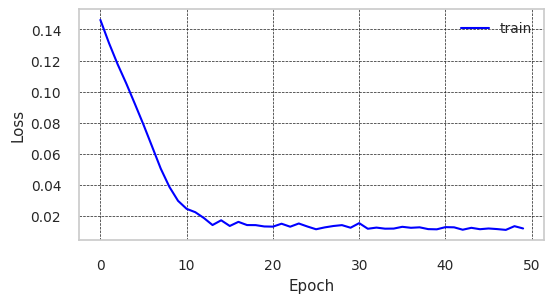

In [70]:
plot_loss(training_metrics, f'bilstm_exp{exp}', figs_dir=plots_dir)

In [71]:
del training_metrics
gc.collect()

15518

In [72]:
best_params = torch.load(os.path.join(weights_dir, f'best_exp_{exp}.pt'))
bilstm_model.load_state_dict(best_params['model'], strict=False)
train_preds, train_losses = predict(bilstm_model, train_loader, config['loss_fn'])

## Scores and threshold Visualization

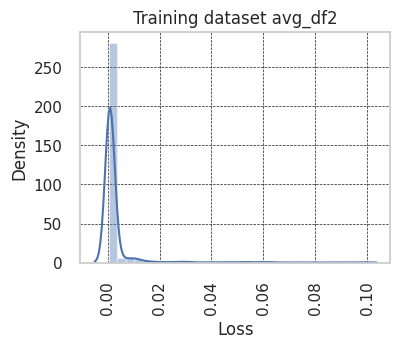

In [73]:
sns.set(rc={'figure.figsize': (4, 3)})
sns.set_style('whitegrid')
sns.distplot(train_losses, bins=30, kde=True)
plt.grid(color ='k', ls= '--', lw=0.5)
plt.xlabel('Loss')
plt.title('Training dataset avg_df2')
plt.xticks(rotation=90)
save_plot(plots_dir, plot_name=f'train_dist_exp{exp}')
plt.show()

In [74]:
np.percentile(train_losses, [0.85, 90, 91, 95, 97, 98, 99])

array([0.00038894, 0.00220847, 0.00261857, 0.00937729, 0.01272682,
       0.02192016, 0.04185622])

In [75]:
threshold = np.round(np.percentile(train_losses, 90), 4)

In [76]:
train_scores = pd.DataFrame(index=avg_df2.index)
loss_column = 'huber_loss' if config['loss_fn'] == huber_loss else 'mae_loss'
train_scores[loss_column] = train_losses
train_scores['Anomaly'] =  [0 if l < threshold else 1 for l in train_losses]
train_scores.to_csv(os.path.join(csv_files, f'bilstm_train_exp{exp}.csv'))

In [77]:
threshold_ = np.array([threshold]*len(train_scores))

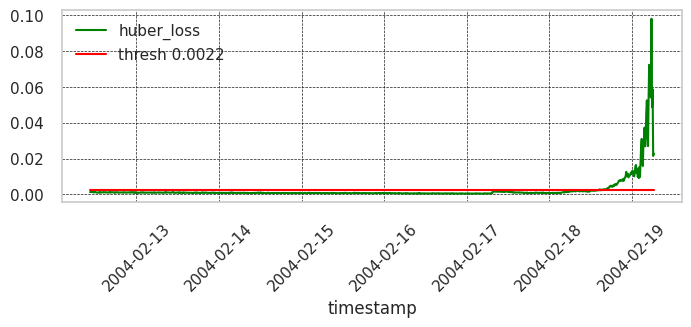

In [78]:
plot_anomaly_threshold(train_scores, plot_name=f'bilstm_thresh_exp{exp}', thresh=threshold_)

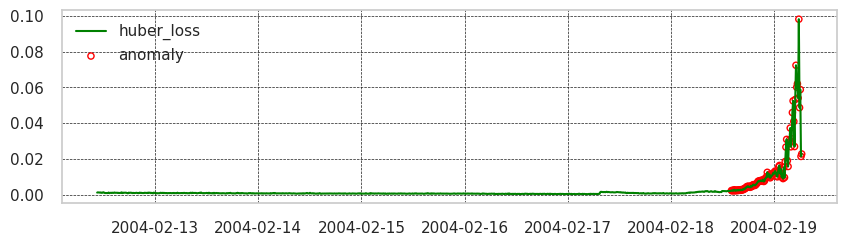

In [79]:
bilstm_predicted_anomalies(train_scores, size=(10, 2.5), plot_name=f'bilstm_val_pred_anom_exp{exp}')

In [80]:
preds_array = scaler.inverse_transform(np.array(train_preds))

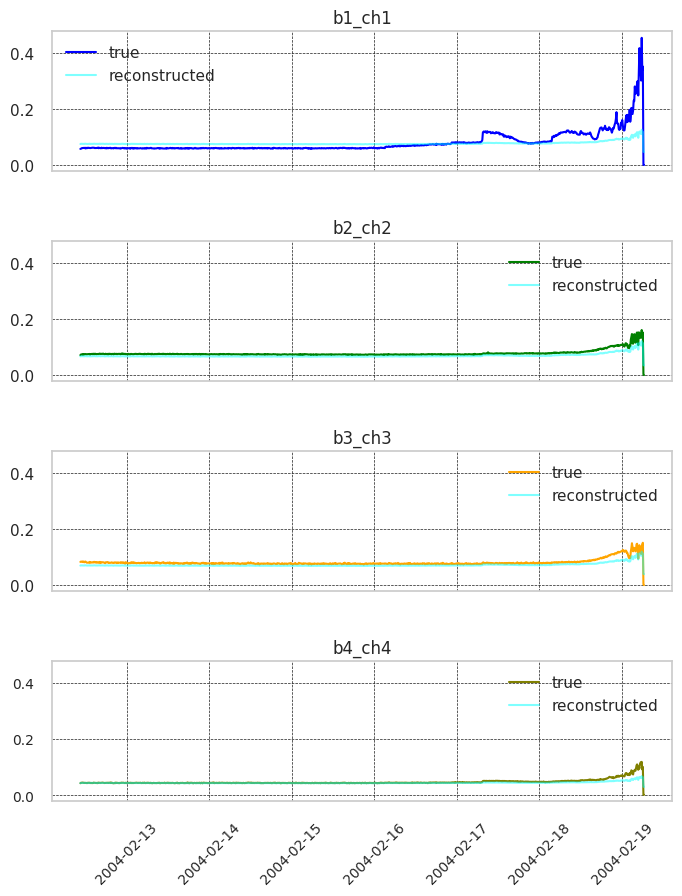

In [81]:
plot_reconstruction(avg_df2, preds_array, plot_name=f'bilstm_rec_exp{exp}')

In [82]:
del train_preds,
del train_losses
del train_scores
gc.collect()

24807

## Predict on unseen data

In [83]:
bilstm_model.load_state_dict(best_params['model'], strict=False)

<All keys matched successfully>

In [84]:
test_preds, test_losses = predict(bilstm_model, test_loader, config['loss_fn'])

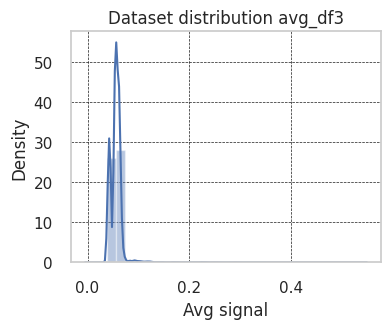

In [85]:
sns.set(rc={'figure.figsize': (4, 3)})
sns.set_style('whitegrid')
sns.distplot(avg_df3.values, bins=30, kde=True)
plt.grid(color ='k', ls= '--', lw=0.5)
plt.xlabel('Avg signal')
plt.title('Dataset distribution avg_df3')
plt.show()

In [86]:
np.quantile(avg_df3.values, [0.8, 0.85, 0.90, 0.95, 0.97, 0.98, 0.99])

array([0.06192544, 0.06287408, 0.06436785, 0.06681847, 0.06948128,
       0.08007517, 0.10683016])

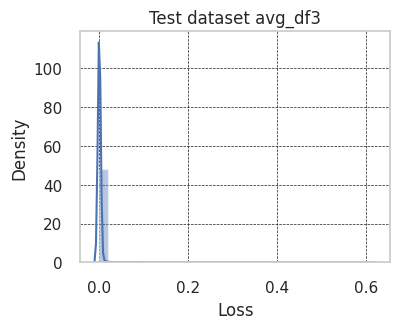

In [87]:
plt.figsize = (5,5)
sns.set_style('whitegrid', {"grid.color": 'k', 'grid.linestyle': '--'})
sns.distplot(test_losses, bins=30, kde=True)
plt.title('Test dataset avg_df3')
plt.xlabel('Loss')
plt.grid(lw=0.5, c='k')
plt.show()

In [88]:
np.percentile(test_losses, [90, 95, 97, 98, 99])

array([0.00106332, 0.00124049, 0.00213738, 0.01091616, 0.04999775])

In [89]:
test_thresh = np.round(np.percentile(test_losses, 97), 4)
test_thresh

0.0021

In [90]:
threshold_ = np.array([test_thresh]*len(test_losses))

In [91]:
test_scores = pd.DataFrame(index=avg_df3.index)
test_scores[loss_column] = test_losses
test_scores['Anomaly'] =  [0 if l < test_thresh else 1 for l in test_losses]
test_scores.to_csv(os.path.join(csv_files, f'bilstm_test_exp{exp}.csv'))

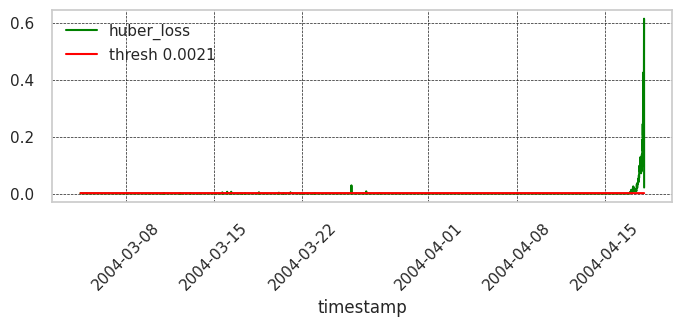

In [92]:
plot_anomaly_threshold(test_scores, thresh=threshold_, plot_name=f'test_thres_bilstm_exp_{exp}')

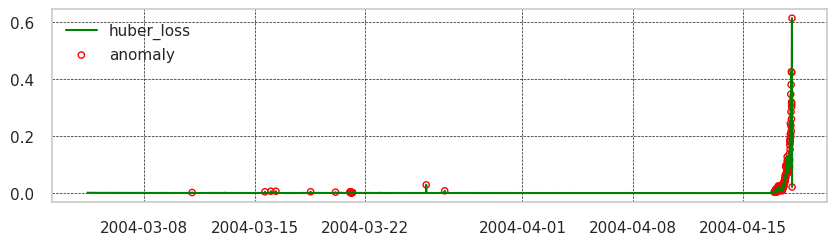

In [93]:
# Loss scores with anomalies
bilstm_predicted_anomalies(test_scores, size=(10, 2.5),
                         plot_name=f'test_bilstm_anom_exp{exp}')

In [94]:
# Revert scaling for reconstuction
test_preds_array = scaler.inverse_transform(np.array(test_preds))

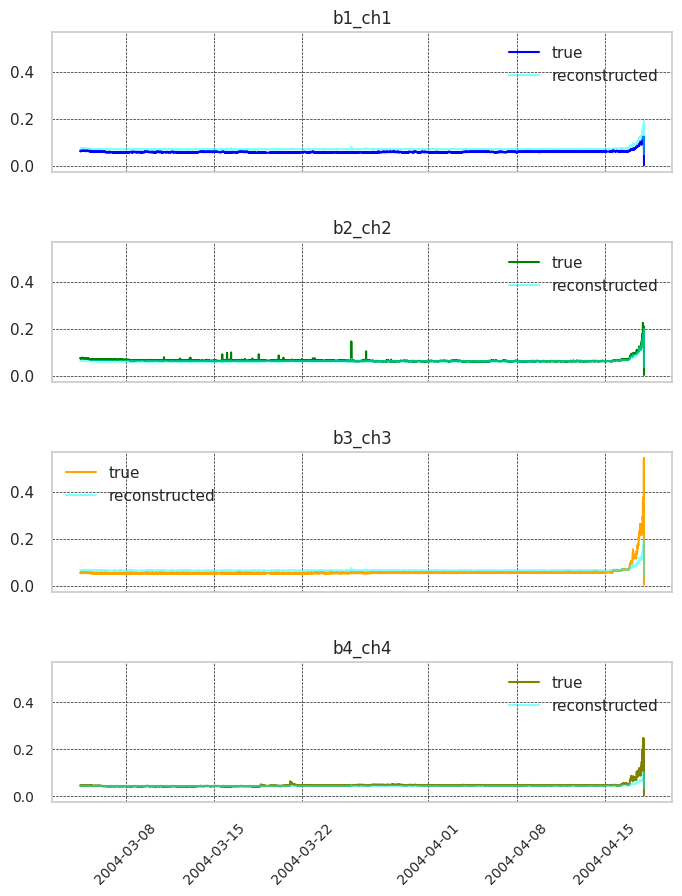

In [95]:
plot_reconstruction(avg_df3, test_preds_array, f'bilstm_test_preds_exp{exp}')

In [96]:
del threshold_, test_preds, test_losses, test_scores, test_preds_array
gc.collect()

25132

## BiLSTM Results

### Train dataset

In [97]:
from models_comparison import merge_csv_files

In [98]:
train_lstm_anomalies = [d for d in dir_list(csv_files) if 'bilstm_train' in d]
print(train_lstm_anomalies)

['bilstm_train_exp4.csv']


In [99]:
bilstm_train_anomalies = merge_csv_files(avg_df2.index, train_lstm_anomalies, path=csv_files)

In [100]:
print('Anomalies detected by model')
print(bilstm_train_anomalies.sum(axis=0))

Anomalies detected by model
exp4    99
dtype: int64


In [101]:
# Filter the timestamps where one or more models detected an anomaly
train_earliest_detect = bilstm_train_anomalies[bilstm_train_anomalies.sum(axis=1) >=1]

# Filter the timestamps where two or more models detected an anomaly
anomalies_two_models = train_earliest_detect[train_earliest_detect.sum(axis=1) > 1]

# Filter the timestamps where all models detected an anomaly on the training dataset
common_training_anomalies = train_earliest_detect[train_earliest_detect.sum(axis=1) ==
                                                len(train_earliest_detect.columns)].index

In [102]:
print('='*102)
print('The model that first detected an anomaly on the train dataset was:')
print(f'{train_earliest_detect.head().sum(axis=0).nlargest(n=1).keys()[0]} starting'
      f' from {train_earliest_detect.index[0]}')
print(' ')
print('='*102)

print(f'Two or more models detected anomalies from {anomalies_two_models.index[0]}')
print(f'Model: {anomalies_two_models.columns[np.where(anomalies_two_models.iloc[0])].values}')
print(' ')
print('='*102)
print(f'All models detected anomalies in the train dataset'
      f' on {len(common_training_anomalies)} timestamps starting from {common_training_anomalies[0]}')
print('')
print('='*102)

The model that first detected an anomaly on the train dataset was:
exp4 starting from 2004-02-18 14:02:39
 


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
print('='*98)
print('The earliest that an anomaly could have been detected by one or more models before failure was:')
print(f'{bilstm_train_anomalies.index[-1] - train_earliest_detect.index[0]}')
print(' ')
print('='*102)
print('The earliest that an anomaly could have been detected by',
        'two or more models before failure was:')
print(f'{bilstm_train_anomalies.index[-1] - bilstm_train_anomalies[bilstm_train_anomalies.sum(axis=1) > 1].index[0]}')
print(' ')
print('='*102)
print(f'The earliest that an anomaly could have been detected by all models before failure'
      f' was: {bilstm_train_anomalies.index[-1] - common_training_anomalies[0]}')
print(' ')
print('='*102)

### Test dataset

In [ ]:
test_lstm_anomalies = [d for d in dir_list(csv_files) if 'bilstm_test' in d]
print(train_lstm_anomalies)

In [152]:
bilstm_test_anomalies = merge_csv_files(avg_df3.index, test_lstm_anomalies, path=csv_files)

In [ ]:
print('Anomalies detected by model:')
bilstm_test_anomalies.sum(axis=0)

In [154]:
detect_test_anomalies = bilstm_test_anomalies[(bilstm_test_anomalies.sum(axis=1)>=1)]

In [ ]:
print('Anomalies detected by model before 2004-04-15')
detect_test_anomalies[detect_test_anomalies.index < '2004-04-15'].sum(axis=0)

In [ ]:
print('Anomalies detected by model from 2004-04-15')
detect_test_anomalies[detect_test_anomalies.index >= '2004-04-15'].sum(axis=0)

In [ ]:
test_tail_anomalies = detect_test_anomalies[detect_test_anomalies.index >= '2004-04-15']
print('Models that first detected an anomaly from 2004-04-15 :')
print(test_tail_anomalies.columns[np.where(test_tail_anomalies.iloc[0]==1)].values)
print(f"Timestamp: {test_tail_anomalies.index[0]}")

In [ ]:
print('Lead time before breakdown from the fisrt detection:')
test_tail_anomalies.index[-1] - test_tail_anomalies.index[0]

In [ ]:
print('Lead time before breakdown detected by at leats two models:')
test_tail_anomalies.index[-1] - test_tail_anomalies[test_tail_anomalies.sum(axis=1)>1].index[0]

In [ ]:
del test_tail_anomalies, detect_test_anomalies
gc.collect()



## Cluster Metrics


In this section, we will utilize three metrics, the silhouette coefficient, Calinski-Harabaz and Davies-Boulding indexes, to assess the cluster quality generated by each unsupervised model.

Note: Adapted from scikit-learn
https://scikit-learn.org/stable/modules/model_evaluation.html#clustering-metrics


1. **Silhouette Score** is the mean Silhouette Coefficient for all clusters, which is calculated using the mean intra-cluster distance and the mean nearest-cluster distance. This score is between -1 and 1; the higher the score, the more well-defined and distinct the clusters are.

1. **Calinski-Harabaz Index** is calculated using the between-cluster and within-cluster dispersion to measure the distinctiveness between groups. Like the Silhouette Score, the higher the score, the more well-defined the clusters are. This score has no bound, meaning no ‘acceptable’ or ‘good’ value exists.

3. **Davies-Bouldin Index** is the average similarity of each cluster with its most similar cluster. Unlike the previous two metrics, this score measures the similarity of the clusters, meaning that the lower the score, the better the separation between the clusters. Zero is the lowest possible score. Values closer to zero indicate a better partition.The usage of centroid distance limits the distance metric to Euclidean space.

The disadvantage of the three metrics is that they generally score higher for convex clusters than other concepts of clusters. Therefore further compare their performance with **non-parametric statistics**.

In [119]:
from models_comparison import concat_dataframes, friedman_conover_comparison, compare_clusters_metrics

In [120]:
from sklearn.metrics import pairwise_distances, silhouette_samples
from sklearn import metrics

In [121]:
def compare_clusters_metrics(df_raw, df_cluster):
    """
    :param df_raw: raw data dataframe
    :param df_cluster: dataframe with cluster labels
    :return: data frame with the cluster metrics scores
    """
    model_scores = {}
    for col in df_cluster.columns:
        sil = metrics.silhouette_score(df_raw, df_cluster[col])
        cal_har = metrics.calinski_harabasz_score(df_raw, df_cluster[col])
        dav_boul = metrics.davies_bouldin_score(df_raw, df_cluster[col])
        model_scores[col] = [sil, cal_har, dav_boul]

    cluster_metrics = pd.DataFrame.from_dict(model_scores).T
    cluster_metrics.columns = ['silhoutte', 'calinski_harabasz', 'davies_bouldin']

    return  cluster_metrics

### Train dataset

In [122]:
# read pycaret anomalies csv file
pc_train_anomalies = read_concat_data(csv_files, 'unsupervised_anomaly_pred.csv')

In [ ]:
# Concatenate training results
training_anomalies = concat_dataframes([pc_train_anomalies, bilstm_train_anomalies])
training_anomalies.to_csv(os.path.join(csv_files, 'training_anomalies.csv'))
training_anomalies.sum(axis=0)

In [ ]:
train_clusters_scores = compare_clusters_metrics(avg_df2, training_anomalies).round(4)
train_clusters_scores

### __Training metrics resulst__

Top Silhoutte scores by model

*   Histogram, IForest, MCD

Top Calinski-Harabasz indexes by model
*   MCD, SVM, Histogram

Top Davies-Bouldin indexes

*   SVM, MCD, Histogram





### Test Dataset

In [133]:
pc_test_anomalies = read_concat_data(csv_files, 'unsupervised_test_anomaly.csv')
test_anomalies = concat_dataframes([pc_test_anomalies, bilstm_test_anomalies])
test_anomalies.to_csv(os.path.join(csv_files, 'test_anomalies.csv'))

In [ ]:
test_anomalies.sum(axis=0)

In [ ]:
test_clusters_scores = compare_clusters_metrics(avg_df3, test_anomalies).round(4)
test_clusters_scores

# Nonparametric  statistical comparison - PyCaret Models vs BiLSTM

In [136]:
from models_comparison import concat_dataframes, friedman_conover_comparison

---
In this section the models will be compared by using nonparametrics statistics. The
distributions are not normal and the data come from repeated measures of the same datasets.

* __Nonparametric test - Friedmanchisquare__
* __Posthoc test - Friedman-Conover__
---

In [ ]:
train_stats, tr_p, train_ranks = friedman_conover_comparison(training_anomalies,
                                                             plot_name='train_models')

In [ ]:
train_ranks.sort_values(axis=0, ascending=False).round(4)

## Test dataset

In [ ]:
test_statistic, test_p, test_ranks = friedman_conover_comparison(test_anomalies,
                                                                 plot_name='test_models')

In [ ]:
print(test_ranks.sort_values(axis=0, ascending=False))

In [ ]:
del pc_train_anomalies, bilstm_train_anomalies, training_anomalies, avg_df2
del pc_test_anomalies, bilstm_test_anomalies, test_anomalies, avg_df3
gc.collect()

# Statistical Summary
---

**Training**


*Cluster Metrics*

The models that obtained the highest Calinski-Harabasz and Davies-Bouldin indexes were SVM, MCV and Histogram. These models, in addition to IForest, showed the highest Silhouette scores.

*Non-parametric Comparison*

Statistically different

* From the nonparametric statistical Conover-Friedman test, we found a significant difference in detecting anomalies among the models with 95 \% certainty.

* For the training dataset, there is no significant difference in the performance of each Pycaret model. However, all BiLSTM experiments were significantly different to all PyCaret models.
* All BiLSTM experiments were not significantly different from each other, as shown in the Friedman-Conover and critical difference diagrams.
* Exp-04 ranked the highest scored but was not significantly different to __Exp-02__ to __Exp-04__. The anomaly could have been detected with 22:00 lead time with Exp-02 and Exp-04, while for the PyCaret models, the Clustering-Based Local outlier **cluster** could have detected the anomalies 14:40 hr in advance.


---

**Test**

*Cluster Metrics*

MCD and SVM obtained the highest Silhouette scores and Calinski-Harabasz and Davies-Bouldin indexes.


* From the nonparametric test, we can reject the null hypothesis that the performance of all models at detecting anomalies is not significantly different with 95% certainty

* The ranking of the models shows that the best model and the Conover-Friedman test and critical difference diagram showed no statistical difference amongst experiments Exp-01 to Exp-04 and iForest with 95% certainty.
* Similarly, MCD and SVM showed no significant difference in detecting anomalies but significantly differed from all other models.

* Experiments Exp-02 and Exp-04 minimised which objective function to minimised was the Huber-Loss ranked the highest of all models.
* The Conover-Friedman test and critical difference diagram showed no statistical difference amongst experiments Exp-01 to Exp-04 and iForest.  
* Any of the BiLSTM models could have detected the anomaly within a 27:00 hr lead time, specifically Exp-03 within 27:20:00, while iforest detected the anomalies within a lead time of 25:30:00.

---


# Conclusion

In summary, Exp-04 consistently obtained the best performance in both datasets. The test dataset was almost six times larger than the train set. It also presented spikes at the beginning and middle of the test. We can observe that the data's size and quality impact the model's choice to detect failures. Models Histogram, Cluster, and KNN were excluded in the test comparison since they accounted for more than 50% in the test dataset which is inacurate as per the data visualisations. These model showed to be less robust for unseen data.

Conversely, the IForest model took the lead in detecting anomalies together with Exp-01 and Exp-04 with no significant difference in their performance for the unseen test dataset. It showed to be more robust to changes independently of datset size and the unknown contamination.

We can conclude that the PyCaret Anomalies models selected in this work and the Bilstm (Bidirectional LSTM) Artificial Neural Networks can detect failures on the bearing sensors' signals at the same performance level. Whether these models can detect failures days or weeks in advance in other unseen data requires further testing and optimisation.